# Customer Segemenation Using RFM Analysis

In this project, I am trying to perform RFM Analysis using the Pyspark.

Dataset is user transaction data which contains view, cart, remove from cart and purchase

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("e-CommerceSegmentation").getOrCreate()

oct_df = spark.read.format("csv").option("header", "true").load("2019-Oct.csv")
nov_df = spark.read.format("csv").option("header", "true").load("2019-Nov.csv")
dec_df = spark.read.format("csv").option("header", "true").load("2019-Dec.csv")
jan_df = spark.read.format("csv").option("header", "true").load("2020-Jan.csv")
feb_df = spark.read.format("csv").option("header", "true").load("2020-Feb.csv")

merged_df = oct_df.union(nov_df).union(dec_df).union(jan_df).union(feb_df)

df = merged_df.sample(fraction=0.1, seed=42)

In [2]:
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [3]:
df.show(5)

+--------------------+----------------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|          event_time|      event_type|product_id|        category_id|category_code|   brand|price|  user_id|        user_session|
+--------------------+----------------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|2019-10-01 00:00:...|            cart|   5825598|1487580009445982239|         null|    null| 0.56|467916806|2f5b5546-b8cb-9ee...|
|2019-10-01 00:00:...|            cart|   5670337|1752742615205281895|         null|    null| 2.38|546705258|3b5c65c0-bb1c-453...|
|2019-10-01 00:00:...|            cart|   5836522|1487580013522845895|         null|nagaraku| 0.40|429681830|49e8d843-adf3-428...|
|2019-10-01 00:01:...|remove_from_cart|   5664641|1487580011425693811|         null|    null| 0.70|429681830|49e8d843-adf3-428...|
|2019-10-01 00:01:...|remove_from_cart|   5827373|1487580009445982239|         null

In [4]:
# Drop rows with missing values
df = df.dropna()


In [5]:
df = df.dropDuplicates()

In [6]:
# Convert a column to a specific data type
df = df.withColumn("product_id", df["product_id"].cast("double"))
df = df.withColumn("price", df["price"].cast("double"))
df = df.withColumn("user_id", df["user_id"].cast("double"))
df = df.withColumn("category_id", df["category_id"].cast("double"))
df = df.withColumn("event_time", df["event_time"].cast("timestamp"))

In [7]:
df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: double (nullable = true)
 |-- category_id: double (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: double (nullable = true)
 |-- user_session: string (nullable = true)



In [8]:
#Transformation

In [9]:
# Group by and count the number of events by event type:
df.groupBy("event_type").count().show()

+----------------+-----+
|      event_type|count|
+----------------+-----+
|        purchase| 1342|
|            view|16805|
|            cart| 5357|
|remove_from_cart| 3040|
+----------------+-----+



In [10]:
df.count()

26544

In [12]:
# Calculate total revenue by customer ID:
import pyspark.sql.functions as F
df.groupBy("user_id").agg(F.sum("price").alias("total_revenue")).show()


+------------+------------------+
|     user_id|     total_revenue|
+------------+------------------+
| 5.5560429E8|              9.52|
|4.69749672E8|               7.3|
|5.64743739E8|             94.44|
|5.65208716E8|            150.79|
|4.84346658E8|              6.98|
|5.72556155E8|             53.17|
| 5.7311298E8|             53.81|
| 4.2302953E8|            116.03|
|4.08795242E8|            592.41|
|5.82758484E8|118.89000000000001|
|4.50840633E8|              1.43|
|5.44065836E8|              3.96|
|5.06824838E8|             24.44|
|5.88731519E8|              1.98|
|6.02050813E8|              6.19|
|5.09218779E8|             82.54|
|6.00170334E8|              7.46|
|5.58525406E8|             94.44|
|4.90615023E8|             24.44|
|5.36694355E8|            131.59|
+------------+------------------+
only showing top 20 rows



In [13]:
#Calculate the average price by category code:
df.groupBy("category_code").agg(F.avg("price").alias("avg_price")).show()


+--------------------+------------------+
|       category_code|         avg_price|
+--------------------+------------------+
| stationery.cartrige|2.2598401354147097|
|furniture.living_...|105.50334837545181|
|furniture.bathroo...|34.214795230689504|
|     accessories.bag| 61.78884520884514|
|appliances.person...| 55.37661016949153|
|appliances.enviro...| 10.19576923076923|
|appliances.enviro...|51.491272969768524|
|accessories.cosme...|14.377539682539682|
|       apparel.glove| 7.496123238463637|
|appliances.person...|  57.5719808306709|
+--------------------+------------------+



# Events Analysis

In [15]:
#Count the number of occurrences for each event type:
event_count = df.groupBy("event_type").count().orderBy("count", ascending=False)
event_count.show()

+----------------+-----+
|      event_type|count|
+----------------+-----+
|            view|16805|
|            cart| 5357|
|remove_from_cart| 3040|
|        purchase| 1342|
+----------------+-----+



In [16]:
# Calculate the percentage distribution of different event types:

total_events = df.count()
event_percentage = event_count.withColumn("percentage", F.col("count") / total_events * 100)
event_percentage.show()


+----------------+-----+------------------+
|      event_type|count|        percentage|
+----------------+-----+------------------+
|            view|16805|63.309975889089806|
|            cart| 5357|20.181585292344785|
|remove_from_cart| 3040|11.452682338758288|
|        purchase| 1342| 5.055756479807113|
+----------------+-----+------------------+



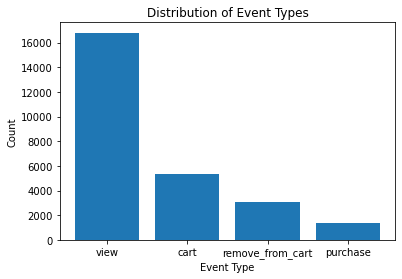

In [17]:
import matplotlib.pyplot as plt

event_counts = event_count.toPandas()
plt.bar(event_counts["event_type"], event_counts["count"])
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.title("Distribution of Event Types")
plt.show()


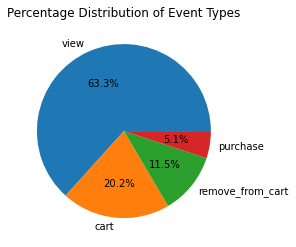

In [18]:
event_percentages = event_percentage.toPandas()
plt.pie(event_percentages["percentage"], labels=event_percentages["event_type"], autopct='%1.1f%%')
plt.title("Percentage Distribution of Event Types")
plt.show()


# Product Category Analysis

In [19]:
# Count the number of occurrences for each category:

category_count = df.groupBy("category_code").count().orderBy("count", ascending=False)
category_count.show()

+--------------------+-----+
|       category_code|count|
+--------------------+-----+
|appliances.enviro...|13496|
| stationery.cartrige| 5317|
|       apparel.glove| 3619|
|furniture.bathroo...| 1929|
|furniture.living_...| 1108|
|     accessories.bag|  407|
|appliances.person...|  313|
|appliances.person...|  177|
|accessories.cosme...|  126|
|appliances.enviro...|   52|
+--------------------+-----+



In [20]:
#Calculate the percentage distribution of different categories:

total_categories = df.select("category_code").distinct().count()
category_percentage = category_count.withColumn("percentage", F.col("count") / total_categories * 100)
category_percentage.show()


+--------------------+-----+------------------+
|       category_code|count|        percentage|
+--------------------+-----+------------------+
|appliances.enviro...|13496|          134960.0|
| stationery.cartrige| 5317| 53170.00000000001|
|       apparel.glove| 3619|           36190.0|
|furniture.bathroo...| 1929|           19290.0|
|furniture.living_...| 1108|           11080.0|
|     accessories.bag|  407|4070.0000000000005|
|appliances.person...|  313|            3130.0|
|appliances.person...|  177|            1770.0|
|accessories.cosme...|  126|            1260.0|
|appliances.enviro...|   52|             520.0|
+--------------------+-----+------------------+



In [21]:
# Identify the top-selling categories based on sales or event counts:

top_categories = category_count.limit(5)
top_categories.show()


+--------------------+-----+
|       category_code|count|
+--------------------+-----+
|appliances.enviro...|13496|
| stationery.cartrige| 5317|
|       apparel.glove| 3619|
|furniture.bathroo...| 1929|
|furniture.living_...| 1108|
+--------------------+-----+



In [22]:
#Analyze the average price or revenue by category:

average_price_by_category = df.groupBy("category_code").avg("price").orderBy("avg(price)", ascending=False)
average_price_by_category.show()


+--------------------+------------------+
|       category_code|        avg(price)|
+--------------------+------------------+
|furniture.living_...|105.50334837545181|
|     accessories.bag| 61.78884520884514|
|appliances.person...|  57.5719808306709|
|appliances.person...| 55.37661016949153|
|appliances.enviro...|51.491272969768524|
|furniture.bathroo...|34.214795230689504|
|accessories.cosme...|14.377539682539682|
|appliances.enviro...| 10.19576923076923|
|       apparel.glove| 7.496123238463637|
| stationery.cartrige|2.2598401354147097|
+--------------------+------------------+



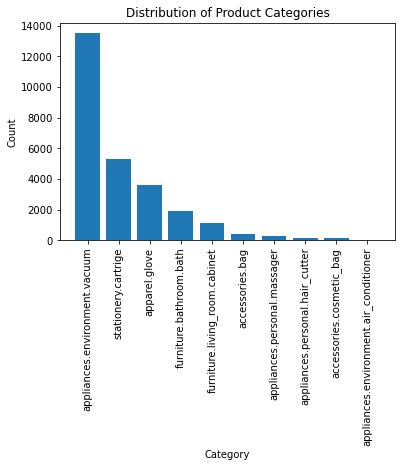

In [23]:
import matplotlib.pyplot as plt

category_counts = category_count.toPandas()
plt.bar(category_counts["category_code"], category_counts["count"])
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of Product Categories")
plt.xticks(rotation=90)
plt.show()


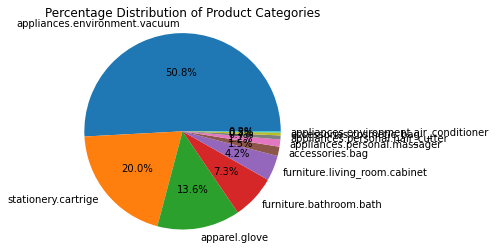

In [24]:
category_percentages = category_percentage.toPandas()
plt.pie(category_percentages["percentage"], labels=category_percentages["category_code"], autopct='%1.1f%%')
plt.title("Percentage Distribution of Product Categories")
plt.axis('equal')
plt.show()


# Brand Analysis

In [25]:
#Count the number of occurrences for each brand:
brand_count = df.groupBy("brand").count().orderBy("count", ascending=False)
brand_count.show()

+---------+-----+
|    brand|count|
+---------+-----+
|  italwax| 4157|
|      max| 3463|
|  polarus| 3111|
|   runail| 2540|
|     emil| 2402|
|   benovy| 2118|
|    irisk| 2099|
| jessnail| 1867|
|depilflax|  805|
|    domix|  774|
| nitrimax|  730|
|  nitrile|  453|
|    vosev|  405|
| kosmekka|  353|
| gezatone|  317|
|     yoko|  146|
|     shik|   98|
|   mavala|   86|
|    dewal|   85|
|     milv|   81|
+---------+-----+
only showing top 20 rows



In [26]:
#Identify the top-selling brands based on sales or event counts:

top_brands = brand_count.limit(5)
top_brands.show()


+-------+-----+
|  brand|count|
+-------+-----+
|italwax| 4157|
|    max| 3463|
|polarus| 3111|
| runail| 2540|
|   emil| 2402|
+-------+-----+



In [27]:
#Analyze the average price or revenue by brand:

average_price_by_brand = df.groupBy("brand").avg("price").orderBy("avg(price)", ascending=False)
average_price_by_brand.show()


+---------+------------------+
|    brand|        avg(price)|
+---------+------------------+
| kosmekka|146.36334277620423|
|   jaguar| 88.08923076923078|
|      max|  69.3235200693046|
|   kondor| 64.55307692307693|
|  polarus| 63.69310511089666|
|    vosev|61.976395061728326|
| gezatone| 57.04564668769714|
|     emil|  52.9116527893424|
|    irisk|41.244349690328654|
|   runail| 39.02587795275601|
| jessnail|37.359169791108854|
| babyliss|30.450000000000003|
|  farmona|22.785531914893618|
| naturmed|21.793999999999997|
|   matrix|21.430000000000003|
| kinetics| 20.37965517241379|
|     shik|            17.145|
|farmavita|             16.42|
|   gehwol|            16.245|
|   cutrin|12.870909090909093|
+---------+------------------+
only showing top 20 rows



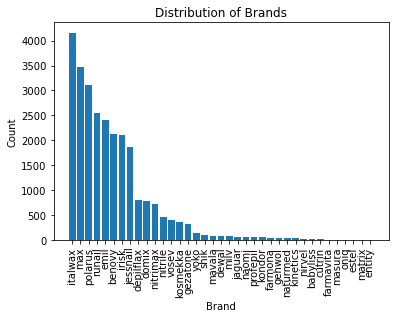

In [28]:
import matplotlib.pyplot as plt

brand_counts = brand_count.toPandas()
plt.bar(brand_counts["brand"], brand_counts["count"])
plt.xlabel("Brand")
plt.ylabel("Count")
plt.title("Distribution of Brands")
plt.xticks(rotation=90)
plt.show()


# Pricing Analsyis

In [34]:
#Calculate basic statistics of price, such as minimum, maximum, mean, and median:

price_statistics = df.select(F.min("price").alias("min_price"),
                             F.max("price").alias("max_price"),
                             F.mean("price").alias("mean_price"))
                             
price_statistics.show()


+---------+---------+-----------------+
|min_price|max_price|       mean_price|
+---------+---------+-----------------+
|     0.94|   284.13|36.62898621157333|
+---------+---------+-----------------+



In [35]:
# Identify any outliers or unusual price values:

# Calculate the lower and upper quartiles
quartiles = df.approxQuantile("price", [0.25, 0.75], 0.05)

# Calculate the interquartile range (IQR)
iqr = quartiles[1] - quartiles[0]

# Calculate the lower and upper bounds for outliers
lower_bound = quartiles[0] - (1.5 * iqr)
upper_bound = quartiles[1] + (1.5 * iqr)

# Filter the dataframe to identify outliers
outliers = df.filter((df["price"] < lower_bound) | (df["price"] > upper_bound))
outliers.show()


+-------------------+----------+----------+--------------------+--------------------+--------+------+------------+--------------------+
|         event_time|event_type|product_id|         category_id|       category_code|   brand| price|     user_id|        user_session|
+-------------------+----------+----------+--------------------+--------------------+--------+------+------------+--------------------+
|2019-10-02 08:44:06|      view| 5771614.0|2.193074740619379...|furniture.living_...|kosmekka|150.79|4.16133388E8|9e5ddd0f-cb33-48b...|
|2019-10-02 11:01:03|      view| 5771614.0|2.193074740619379...|furniture.living_...|kosmekka|150.79|5.56057482E8|bdcb4966-70df-4c3...|
|2019-10-02 02:33:11|      view| 5771614.0|2.193074740619379...|furniture.living_...|kosmekka|150.79|5.55893418E8|6b35e217-bd3e-472...|
|2019-10-03 15:23:02|      view| 5771614.0|2.193074740619379...|furniture.living_...|kosmekka|150.79|5.56504402E8|04057710-4db2-475...|
|2019-10-01 05:25:43|      view| 5771614.0|2.193

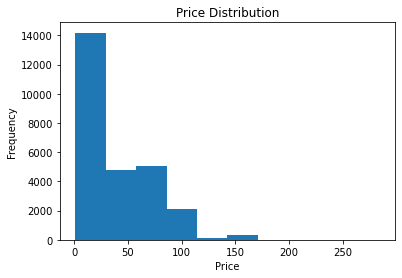

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to pandas DataFrame
pandas_df = df.select("price").toPandas()

# Create a histogram of price distribution
plt.hist(pandas_df["price"], bins=10)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Price Distribution")
plt.show()


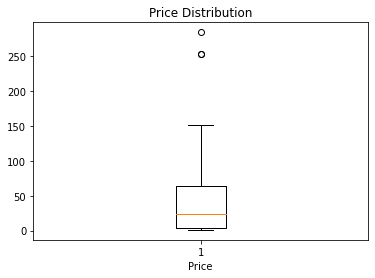

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to pandas DataFrame
pandas_df = df.select("price").toPandas()

# Create a box plot of price distribution
plt.boxplot(pandas_df["price"])
plt.xlabel("Price")
plt.title("Price Distribution")
plt.show()


# User Analysis

In [42]:
unique_users = df.select("user_id").distinct().count()
print("Number of unique users:", unique_users)


Number of unique users: 17939


In [43]:
#Analyze the frequency of user sessions:

session_count = df.groupBy("user_id", "user_session").count().groupBy("user_id").agg(F.count("user_session").alias("session_count"))
session_count.show()


+------------+-------------+
|     user_id|session_count|
+------------+-------------+
|5.55769702E8|            1|
|2.98810722E8|            1|
| 5.5560429E8|            1|
|5.49799296E8|            1|
|5.56723825E8|            1|
|4.49988765E8|            1|
|5.53837618E8|            2|
|  5.583004E8|            1|
|5.48829421E8|            1|
| 4.2302953E8|            2|
|5.17814958E8|            2|
|5.62986868E8|            1|
| 5.0022196E8|            2|
|4.69749672E8|            2|
|5.64653175E8|            1|
|4.57648356E8|            1|
|5.64043962E8|            1|
|4.66996237E8|            1|
|4.84346658E8|            2|
|5.64743739E8|            1|
+------------+-------------+
only showing top 20 rows



In [44]:
#Identify the top users based on the number of events or revenue generated:

top_users_events = df.groupBy("user_id").count().orderBy("count", ascending=False).limit(5)
top_users_events.show()

# If revenue information is available, you can also identify top users based on revenue generated:
top_users_revenue = df.groupBy("user_id").agg(F.sum("price").alias("revenue")).orderBy("revenue", ascending=False).limit(5)
top_users_revenue.show()


+------------+-----+
|     user_id|count|
+------------+-----+
|4.00419007E8|   35|
|4.61327949E8|   23|
|5.57616099E8|   22|
|5.58545016E8|   21|
|3.69925412E8|   17|
+------------+-----+

+------------+-------+
|     user_id|revenue|
+------------+-------+
|4.00419007E8|2652.37|
|5.92324341E8|1204.29|
|5.57616099E8|1096.27|
|4.66445018E8|1019.53|
|4.16042991E8| 959.13|
+------------+-------+



In [45]:
# Analyze the recency of user activity by calculating the time elapsed since their last event:

from pyspark.sql.functions import current_timestamp

user_recency = df.groupBy("user_id").agg(F.max("event_time").alias("last_event_time"))
user_recency = user_recency.withColumn("recency", F.datediff(F.current_timestamp(), F.col("last_event_time")))
user_recency.show()


+------------+-------------------+-------+
|     user_id|    last_event_time|recency|
+------------+-------------------+-------+
| 5.5560429E8|2019-10-01 07:24:44|   1322|
|2.98810722E8|2019-10-01 10:51:49|   1322|
|5.55769702E8|2019-10-01 15:35:27|   1322|
|5.55514612E8|2019-10-01 02:38:14|   1322|
|5.15739868E8|2019-10-02 07:42:42|   1321|
|5.54542689E8|2019-10-01 13:16:12|   1322|
|5.50277678E8|2019-10-02 13:34:01|   1321|
|5.56119062E8|2019-10-02 14:32:31|   1321|
|5.56688367E8|2019-10-04 07:40:11|   1319|
|5.49854453E8|2019-09-30 21:38:03|   1323|
|4.77166035E8|2020-01-28 07:20:24|   1203|
|5.29001782E8|2019-10-03 04:13:33|   1320|
|2.51352373E8|2019-10-03 04:44:46|   1320|
|5.33851435E8|2019-10-01 02:07:55|   1322|
|5.39899399E8|2019-12-13 05:28:46|   1249|
|3.97434246E8|2019-10-02 04:13:55|   1321|
|5.22797178E8|2019-10-03 13:56:28|   1320|
|5.54652133E8|2020-01-02 13:00:17|   1229|
|5.36065234E8|2019-10-03 14:44:18|   1320|
|2.75824683E8|2019-10-03 15:55:15|   1320|
+----------

In [46]:
# Calculate recency, frequency, and monetary value for each user
rfm_analysis = df.groupBy("user_id").agg(
    F.datediff(F.current_timestamp(), F.max("event_time")).alias("recency"),
    F.count("event_time").alias("frequency"),
    F.sum("price").alias("monetary")
)

rfm_analysis.show()


+------------+-------+---------+------------------+
|     user_id|recency|frequency|          monetary|
+------------+-------+---------+------------------+
| 5.5560429E8|   1322|        1|              9.52|
|4.69749672E8|   1297|        2|               7.3|
|5.64743739E8|   1296|        1|             94.44|
|5.65208716E8|   1295|        1|            150.79|
|4.84346658E8|   1288|        3|              6.98|
|5.72556155E8|   1275|        1|             53.17|
| 5.7311298E8|   1274|        1|             53.81|
| 4.2302953E8|   1267|        2|            116.03|
|4.08795242E8|   1220|        7|            592.41|
|5.82758484E8|   1249|        2|118.89000000000001|
|4.50840633E8|   1241|        1|              1.43|
|5.44065836E8|   1240|        2|              3.96|
|5.06824838E8|   1226|        1|             24.44|
|5.88731519E8|   1221|        1|              1.98|
|6.02050813E8|   1211|        1|              6.19|
|5.09218779E8|   1208|        1|             82.54|
|6.00170334E

# Time Series Analysis

In [47]:
# Analyze the distribution of events over time, such as by day, month, or year:

# Extract the date, month, and year from the event_time column
df = df.withColumn("event_date", F.to_date("event_time"))
df = df.withColumn("event_month", F.month("event_time"))
df = df.withColumn("event_year", F.year("event_time"))

# Count the number of events by date, month, or year
event_count_by_date = df.groupBy("event_date").count().orderBy("event_date")
event_count_by_month = df.groupBy("event_month").count().orderBy("event_month")
event_count_by_year = df.groupBy("event_year").count().orderBy("event_year")

event_count_by_date.show()
event_count_by_month.show()
event_count_by_year.show()


+----------+-----+
|event_date|count|
+----------+-----+
|2019-09-30|    5|
|2019-10-01|  188|
|2019-10-02|  214|
|2019-10-03|  167|
|2019-10-04|  129|
|2019-10-05|  130|
|2019-10-06|  185|
|2019-10-07|  193|
|2019-10-08|  145|
|2019-10-09|  154|
|2019-10-10|  195|
|2019-10-11|  103|
|2019-10-12|  128|
|2019-10-13|  158|
|2019-10-14|  186|
|2019-10-15|  171|
|2019-10-16|  162|
|2019-10-17|  106|
|2019-10-18|  149|
|2019-10-19|  125|
+----------+-----+
only showing top 20 rows

+-----------+-----+
|event_month|count|
+-----------+-----+
|          1| 5723|
|          2| 6049|
|          9|    5|
|         10| 4785|
|         11| 5675|
|         12| 4307|
+-----------+-----+

+----------+-----+
|event_year|count|
+----------+-----+
|      2019|14772|
|      2020|11772|
+----------+-----+



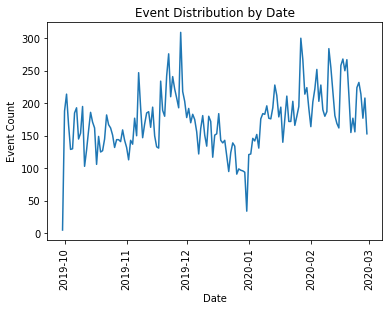

In [48]:
# Identify peak activity periods or seasonality patterns:

event_count_by_date_pd = event_count_by_date.toPandas()
plt.plot(event_count_by_date_pd["event_date"], event_count_by_date_pd["count"])
plt.xlabel("Date")
plt.ylabel("Event Count")
plt.title("Event Distribution by Date")
plt.xticks(rotation=90)
plt.show()


In [49]:
# Analyzing the average price or revenue trends over time:

# Extract the date, month, and year from the event_time column (if not done already)
df = df.withColumn("event_date", F.to_date("event_time"))
df = df.withColumn("event_month", F.month("event_time"))
df = df.withColumn("event_year", F.year("event_time"))

# Calculate the average price or revenue by date, month, or year
average_price_by_date = df.groupBy("event_date").avg("price").orderBy("event_date")
average_price_by_month = df.groupBy("event_month").avg("price").orderBy("event_month")
average_price_by_year = df.groupBy("event_year").avg("price").orderBy("event_year")

average_price_by_date.show()
average_price_by_month.show()
average_price_by_year.show()


+----------+------------------+
|event_date|        avg(price)|
+----------+------------------+
|2019-09-30|             40.84|
|2019-10-01|41.866489361702136|
|2019-10-02|44.468504672897204|
|2019-10-03| 34.34586826347305|
|2019-10-04|40.145968992248065|
|2019-10-05| 32.90930769230769|
|2019-10-06|  34.2531891891892|
|2019-10-07|  33.7379792746114|
|2019-10-08| 40.39206896551725|
|2019-10-09|31.436103896103894|
|2019-10-10| 36.61471794871795|
|2019-10-11| 36.69145631067961|
|2019-10-12|      39.792734375|
|2019-10-13| 37.31892405063292|
|2019-10-14| 33.16618279569894|
|2019-10-15|40.622280701754384|
|2019-10-16|31.917901234567907|
|2019-10-17| 33.58066037735849|
|2019-10-18| 41.15375838926175|
|2019-10-19| 42.43088000000001|
+----------+------------------+
only showing top 20 rows

+-----------+------------------+
|event_month|        avg(price)|
+-----------+------------------+
|          1| 35.45823344399806|
|          2|37.150955529839834|
|          9|             40.84|
|       

In [50]:
#Analyzing the duration or average session time:

df = df.withColumn("session_start", F.substring_index("user_session", "-", 1))
df = df.withColumn("session_end", F.substring_index("user_session", "-", -1))

df = df.withColumn("session_duration", F.unix_timestamp("session_end") - F.unix_timestamp("session_start"))
average_session_time = df.groupBy("user_id").avg("session_duration").orderBy("avg(session_duration)")

average_session_time.show()


+------------+---------------------+
|     user_id|avg(session_duration)|
+------------+---------------------+
| 5.5560429E8|                 null|
|4.69749672E8|                 null|
|5.64743739E8|                 null|
|5.65208716E8|                 null|
|4.84346658E8|                 null|
|5.72556155E8|                 null|
| 5.7311298E8|                 null|
| 4.2302953E8|                 null|
|4.08795242E8|                 null|
|5.82758484E8|                 null|
|4.50840633E8|                 null|
|5.44065836E8|                 null|
|5.06824838E8|                 null|
|5.88731519E8|                 null|
|6.02050813E8|                 null|
|5.09218779E8|                 null|
|6.00170334E8|                 null|
|5.58525406E8|                 null|
|4.90615023E8|                 null|
|5.36694355E8|                 null|
+------------+---------------------+
only showing top 20 rows



# Advanced Analytics

In [60]:
from pyspark.sql.functions import col, max, datediff, current_date
from pyspark.sql.window import Window

windowSpec = Window.partitionBy("user_id")
recency_df = df.withColumn("recency", datediff(current_date(), max("event_time").over(windowSpec)))

frequency_df = df.groupBy("user_id").agg(count("event_type").alias("frequency"))

monetary_df = df.groupBy("user_id").agg(sum("price").alias("monetary_value"))

clv_df = df.groupBy("user_id").agg(sum("price").alias("customer_lifetime_value"))

average_order_value_df = df.groupBy("user_id").agg(avg("price").alias("average_order_value"))

purchase_history_df = df.groupBy("user_id", "category_id", "brand").agg(count("*").alias("purchase_count"))


average_price_per_customer_df = df.groupBy("user_id").agg(avg("price").alias("average_price_per_customer"))

features_df = frequency_df.join(monetary_df, "user_id", "inner") \
    .join(clv_df, "user_id", "inner") \
    .join(average_order_value_df, "user_id", "inner") \
    .join(purchase_history_df, ["user_id"], "inner") \
    .join(average_price_per_customer_df, "user_id", "inner") \
    .join(recency_df.select("user_id", "recency"), "user_id", "inner")

features_df.show()

+------------+---------+--------------+-----------------------+-------------------+--------------------+---------+--------------+--------------------------+-------+
|     user_id|frequency|monetary_value|customer_lifetime_value|average_order_value|         category_id|    brand|purchase_count|average_price_per_customer|recency|
+------------+---------+--------------+-----------------------+-------------------+--------------------+---------+--------------+--------------------------+-------+
| 5.5560429E8|        1|          9.52|                   9.52|               9.52|2.007399943458784E18|  nitrile|             1|                      9.52|   1322|
|4.69749672E8|        2|           7.3|                    7.3|               3.65|1.487580013053083...|  italwax|             2|                      3.65|   1297|
|4.69749672E8|        2|           7.3|                    7.3|               3.65|1.487580013053083...|  italwax|             2|                      3.65|   1297|
|5.6474373

In [61]:
features_df.printSchema()

root
 |-- user_id: double (nullable = true)
 |-- frequency: long (nullable = false)
 |-- monetary_value: double (nullable = true)
 |-- customer_lifetime_value: double (nullable = true)
 |-- average_order_value: double (nullable = true)
 |-- category_id: double (nullable = true)
 |-- brand: string (nullable = true)
 |-- purchase_count: long (nullable = false)
 |-- average_price_per_customer: double (nullable = true)
 |-- recency: integer (nullable = true)



In [62]:
from pyspark.sql.functions import col

segmentation_df = features_df.select(
    col("user_id"),
    col("frequency"),
    col("recency"),
    col("average_order_value"),
    col("customer_lifetime_value"),
    col("average_price_per_customer"),
    col("purchase_count"),
    col("category_id"),
    col("brand")
)

segmentation_df.show()


+------------+---------+-------+-------------------+-----------------------+--------------------------+--------------+--------------------+--------+
|     user_id|frequency|recency|average_order_value|customer_lifetime_value|average_price_per_customer|purchase_count|         category_id|   brand|
+------------+---------+-------+-------------------+-----------------------+--------------------------+--------------+--------------------+--------+
| 5.5560429E8|        1|   1322|               9.52|                   9.52|                      9.52|             1|2.007399943458784E18| nitrile|
|2.98810722E8|        2|   1322|              30.16|                  60.32|                     30.16|             1|1.487580006350586...|   irisk|
|2.98810722E8|        2|   1322|              30.16|                  60.32|                     30.16|             1|1.487580006350586...|   irisk|
|2.98810722E8|        2|   1322|              30.16|                  60.32|                     30.16|   

In [67]:
segmentation_df.printSchema()

root
 |-- user_id: double (nullable = true)
 |-- frequency: long (nullable = false)
 |-- recency: integer (nullable = true)
 |-- average_order_value: double (nullable = true)
 |-- customer_lifetime_value: double (nullable = true)
 |-- average_price_per_customer: double (nullable = true)
 |-- purchase_count: long (nullable = false)
 |-- category_id: double (nullable = true)
 |-- brand: string (nullable = true)



In [69]:
from pyspark.sql.functions import when, col
from pyspark.sql.window import Window

# Quartiles for Recency, Frequency, and Monetary Value
recency_quartiles = segmentation_df.approxQuantile("recency", [0.25, 0.5, 0.75], 0.0)
frequency_quartiles = segmentation_df.approxQuantile("frequency", [0.25, 0.5, 0.75], 0.0)
monetary_quartiles = segmentation_df.approxQuantile("customer_lifetime_value", [0.25, 0.5, 0.75], 0.0)

# Assign segment labels based on quartile values
segmentation_df = segmentation_df.withColumn("recency_segment",
    when(col("recency") <= recency_quartiles[0], "High-Recency")
    .when(col("recency") <= recency_quartiles[1], "Medium-Recency")
    .otherwise("Low-Recency")
)

segmentation_df = segmentation_df.withColumn("frequency_segment",
    when(col("frequency") <= frequency_quartiles[0], "Low-Frequency")
    .when(col("frequency") <= frequency_quartiles[1], "Medium-Frequency")
    .otherwise("High-Frequency")
)

segmentation_df = segmentation_df.withColumn("monetary_segment",
    when(col("customer_lifetime_value") <= monetary_quartiles[0], "Low-Value")
    .when(col("customer_lifetime_value") <= monetary_quartiles[1], "Medium-Value")
    .otherwise("High-Value")
)

# Showing resulting segmentation DataFrame with RFM segments
segmentation_df.show()


+------------+---------+-------+-------------------+-----------------------+--------------------------+--------------+--------------------+---------+---------------+-----------------+----------------+
|     user_id|frequency|recency|average_order_value|customer_lifetime_value|average_price_per_customer|purchase_count|         category_id|    brand|recency_segment|frequency_segment|monetary_segment|
+------------+---------+-------+-------------------+-----------------------+--------------------------+--------------+--------------------+---------+---------------+-----------------+----------------+
| 5.5560429E8|        1|   1322|               9.52|                   9.52|                      9.52|             1|2.007399943458784E18|  nitrile|    Low-Recency|    Low-Frequency|       Low-Value|
|4.69749672E8|        2|   1297|               3.65|                    7.3|                      3.65|             2|1.487580013053083...|  italwax|    Low-Recency| Medium-Frequency|       Low-Va

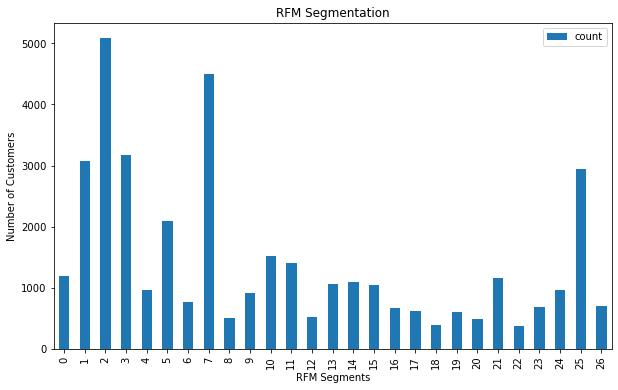

In [70]:
import matplotlib.pyplot as plt

rfm_counts = segmentation_df.groupby("recency_segment", "frequency_segment", "monetary_segment").count().toPandas()

fig, ax = plt.subplots(figsize=(10, 6))
rfm_counts.plot(kind="bar", stacked=True, ax=ax)

ax.set_xlabel("RFM Segments")
ax.set_ylabel("Number of Customers")
ax.set_title("RFM Segmentation")

# Show the plot
plt.show()


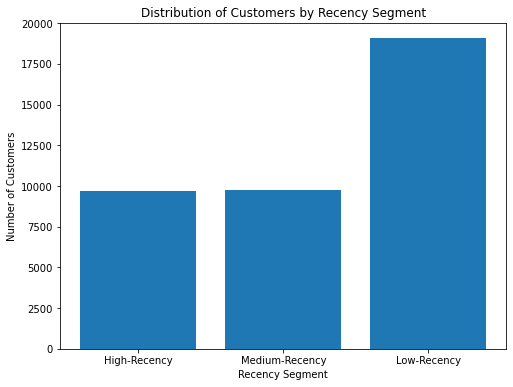

In [71]:
recency_counts = segmentation_df.groupby("recency_segment").count().toPandas()

# Plot the distribution of customers within Recency segments
plt.figure(figsize=(8, 6))
plt.bar(recency_counts["recency_segment"], recency_counts["count"])
plt.xlabel("Recency Segment")
plt.ylabel("Number of Customers")
plt.title("Distribution of Customers by Recency Segment")
plt.show()

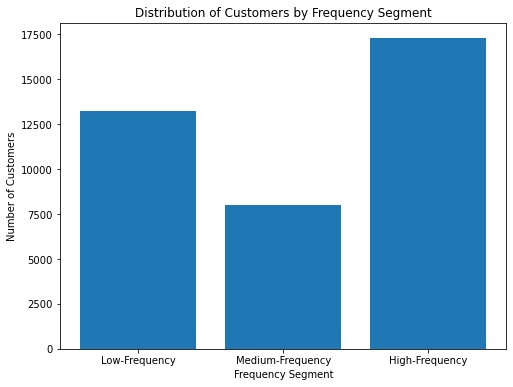

In [73]:
# Plot the distribution of customers within Frequency segments
frequency_counts = segmentation_df.groupby("frequency_segment").count().toPandas()

plt.figure(figsize=(8, 6))
plt.bar(frequency_counts["frequency_segment"], frequency_counts["count"])
plt.xlabel("Frequency Segment")
plt.ylabel("Number of Customers")
plt.title("Distribution of Customers by Frequency Segment")
plt.show()

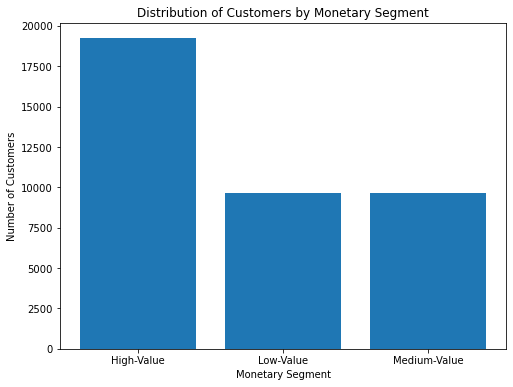

In [74]:
monetary_counts = segmentation_df.groupby("monetary_segment").count().toPandas()

# Plot the distribution of customers within Monetary segments
plt.figure(figsize=(8, 6))
plt.bar(monetary_counts["monetary_segment"], monetary_counts["count"])
plt.xlabel("Monetary Segment")
plt.ylabel("Number of Customers")
plt.title("Distribution of Customers by Monetary Segment")
plt.show()


In [78]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

clustering_df = segmentation_df.select("frequency", "recency", "average_order_value")

assembler = VectorAssembler(inputCols=clustering_df.columns, outputCol="features")
feature_vector = assembler.transform(clustering_df)

kmeans = KMeans(k=4, seed=42)
model = kmeans.fit(feature_vector)

segmentation_results = model.transform(feature_vector)

segmentation_results.show()


+---------+-------+-------------------+--------------------+----------+
|frequency|recency|average_order_value|            features|prediction|
+---------+-------+-------------------+--------------------+----------+
|        1|   1322|               9.52|   [1.0,1322.0,9.52]|         3|
|        2|   1297|               3.65|   [2.0,1297.0,3.65]|         3|
|        2|   1297|               3.65|   [2.0,1297.0,3.65]|         3|
|        1|   1296|              94.44|  [1.0,1296.0,94.44]|         1|
|        1|   1295|             150.79| [1.0,1295.0,150.79]|         1|
|        3|   1288| 2.3266666666666667|[3.0,1288.0,2.326...|         3|
|        3|   1288| 2.3266666666666667|[3.0,1288.0,2.326...|         3|
|        3|   1288| 2.3266666666666667|[3.0,1288.0,2.326...|         3|
|        3|   1288| 2.3266666666666667|[3.0,1288.0,2.326...|         3|
|        3|   1288| 2.3266666666666667|[3.0,1288.0,2.326...|         3|
|        3|   1288| 2.3266666666666667|[3.0,1288.0,2.326...|    

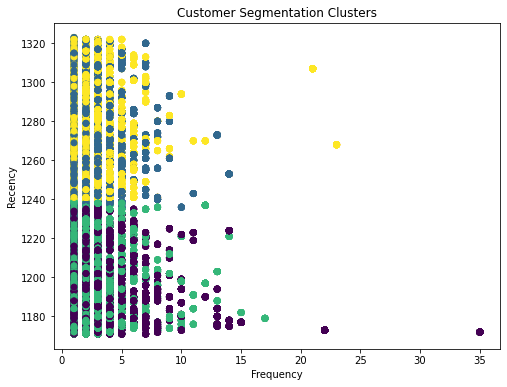

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

pandas_df = segmentation_results.toPandas()

cluster_labels = pandas_df["prediction"]
frequency_values = pandas_df["frequency"]
recency_values = pandas_df["recency"]

plt.figure(figsize=(8, 6))
plt.scatter(frequency_values, recency_values, c=cluster_labels, cmap="viridis")
plt.xlabel("Frequency")
plt.ylabel("Recency")
plt.title("Customer Segmentation Clusters")
plt.show()
